# Second Order ODE Discovery Via Deep Hidden Models

Physics discovery in machine learning is an emerging field focused on using data-driven methods not just to predict physical behavior, but to uncover the underlying physical laws themselves. Instead of assuming that governing equations are known beforehand, these approaches aim to infer them directly from observational or simulated data.

In this notebook I created an interactive example, based on https://arxiv.org/abs/1801.06637 for a physiscs discovery procedure to determine a second order differential operator parametrized by a MLP $L_\phi$ that models an arbitrary function $f:\Omega\mapsto\mathbb{R}$ given several noisy observations $(x_i,y_i)$. A PINN model $u_\theta$ is used to solve the ODE

$$L_\phi[u_\theta](x) = 0$$

while preserving the structure of the original data (i.e. $u_\theta(x_i)\approx y_i$)

In [1]:
import torch
import numpy as np

import matplotlib.pyplot as plt
from torch.nn import Sequential, Linear, ReLU, Tanh
from torch.optim import Adam
from torch.nn.functional import mse_loss

from tqdm.notebook import tqdm

## Data generation

Given some function $f:\mathbb{R}\rightarrow\mathbb{R}$, lets generate a random sample of $N$ observations $\{x_i\}_{i=1}^N$ from the $\text{Unifrom}([0,1])$ distribution and use them to compute $y_i = f(x_i) + \epsilon_i$ where $\epsilon\sim\mathcal{N}(0,\sigma^2)$. Feel free to modify the data generation procedure.

In [2]:
def gen_data(N:int, real_fun, sigma:float=0.1, device:str="cuda"):
    x = torch.rand((N,1),device=device)
    y = real_fun(x)
    noise = torch.randn((N,1),device=device)*sigma
    return x, y + noise

In [3]:
real_fun=lambda x: 3*torch.cos(3*2*torch.pi*x) + 2*torch.sin(4*2*torch.pi*x) + 1*torch.sin(7*2*torch.pi*x)

In [12]:
x_train, y_train = gen_data(
    N=100,
    real_fun=real_fun,
    sigma=0.15,
    device="cuda"
)

In [13]:
x_test = torch.linspace(x_train.min(), x_train.max(), 200, device="cuda", requires_grad=True).reshape(-1,1)

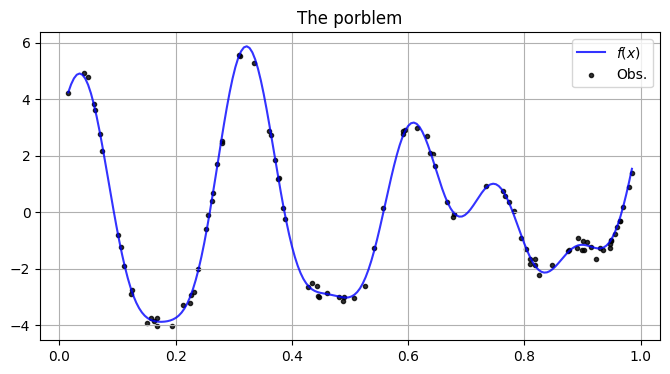

In [66]:
fig = plt.figure(figsize=(8,4))
plt.title("The porblem")
with torch.no_grad():
    plt.plot(
        x_test.flatten().cpu(),
        real_fun(x_test).flatten().cpu(),
        alpha=0.8,
        color="blue",
        label=r"$f(x)$"
    )
    plt.scatter(
        x_train.flatten().cpu(),
        y_train.flatten().cpu(),
        alpha=0.8,
        marker=".",
        color="black",
        label="Obs."
    )
plt.legend()
plt.grid()
plt.show()

For the following sections, lets define a simple procedure to determine the first and second derivatives from a ```torch.tensor``` of shape $(N,1)$

In [21]:
def compute_derivatives(y,x):
    Dy = torch.autograd.grad(
        outputs=y,
        inputs=x,
        grad_outputs=torch.ones_like(y),
        create_graph=True
    )[0]

    D2y = torch.autograd.grad(
        outputs=Dy,
        inputs=x,
        grad_outputs=torch.ones_like(Dy),
        create_graph=True
    )[0]

    diff_terms = torch.hstack([x,y,Dy,D2y])

    return diff_terms

Now, to test the usability of this method, I compare the neural ODE method with a classic MLP regressor and a PINN solution on the trained differential operator.

## Classic Regressor

Let $w_\psi$ be a MLP trained to solve the classic regression problem
$$\argmin_\psi \frac{1}{N}\sum_{i=1}^N\left(w_\psi(x_i) - y_i\right)^2$$

In [17]:
w = Sequential(
    Linear(1,100),
    Tanh(),
    Linear(100,50),
    Tanh(),
    Linear(50,1)
).cuda()

history_w = []

In [18]:
optim_w = Adam(w.parameters(), lr=5e-3)
n_epochs = 1000
pbar = tqdm(total=n_epochs, desc="Training...")

zero_vals = torch.zeros_like(y_train)
x_train.requires_grad_(True)

counter = 0
for epoch in range(n_epochs):
    
    y_pred = w(x_train)

    loss = mse_loss(y_pred.flatten(), y_train.flatten())

    optim_w.zero_grad()
    loss.backward()
    optim_w.step()

    history_w.append(loss.cpu().item())
    pbar.update(1)
    pbar.set_postfix({"loss":history_w[-1]})

    if counter > 10:
        if np.mean(np.abs(np.diff(np.log(history_w[-10:])))) > 0.2:
            for param_group in optim_w.param_groups:
                param_group['lr'] *= 0.8
    counter+= 1

Training...:   0%|          | 0/1000 [00:00<?, ?it/s]

## ODE Discovery Model

As mentioned in the introduction, let $L_\phi$ and $u_\theta$ be MLP's trained to solve the following problem
$$\argmin_{\phi,\theta}\frac{1}{N}\sum_{i=1}^N\left(u_\theta(x_i) - y_i\right)^2 + L_\phi\left(x_i,y_i,D_xu_\theta(x_i),D^2_xu_\theta(x_i)\right)^2$$

In [ ]:
u = Sequential(
    Linear(1,100),
    Tanh(),
    Linear(100,50),
    Tanh(),
    Linear(50,1)
).cuda()

L = Sequential(
    Linear(4,100),
    Tanh(),
    Linear(100,100),
    Tanh(),
    Linear(100,1)
).cuda()

history_u = []

In [ ]:
optim_u = Adam([*u.parameters(),*L.parameters()], lr=5e-3, weight_decay=1e-4)
n_epochs = 1000
pbar = tqdm(total=n_epochs, desc="Training...")

zero_vals = torch.zeros_like(y_train)
x_train.requires_grad_(True)
counter = 0
for epoch in range(n_epochs):
    
    y_pred = u(x_train)
    res_pred = L(compute_derivatives(y_pred,x_train))

    loss = (
        mse_loss(y_pred.flatten(), y_train.flatten()) +
        mse_loss(res_pred.flatten(), zero_vals.flatten())
    )

    optim_u.zero_grad()
    loss.backward()
    optim_u.step()

    history_u.append(loss.cpu().item())
    pbar.update(1)
    pbar.set_postfix({"loss":history_u[-1]})

    if counter > 10:
        if np.mean(np.abs(np.diff(np.log(history_u[-10:])))) > 0.2:
            for param_group in optim_u.param_groups:
                param_group['lr'] *= 0.8
    counter+= 1

Training...:   0%|          | 0/1000 [00:00<?, ?it/s]

## PINN for fixed ODE

Now, just for comparision, lets fix the differential operator $L_{\hat\phi}$ and solve the equation for a new MLP $v_\tau$ 

$$\argmin_{\tau}\frac{1}{N}\sum_{i=1}^N\left(v_\tau(x_i) - y_i\right)^2 + L_{\hat\phi}\left(x_i,y_i,D_xv_\tau(x_i),D^2_xv_\tau(x_i)\right)^2$$

In [25]:
v = Sequential(
    Linear(1,100),
    Tanh(),
    Linear(100,50),
    Tanh(),
    Linear(50,1)
).cuda()

history_v = []

In [27]:
optim_v = Adam(v.parameters(), lr=5e-3,  weight_decay=1e-4)
n_epochs = 1000
pbar = tqdm(total=n_epochs, desc="Training...")

counter = 0
zero_vals = torch.zeros((200,),device="cuda")
for epoch in range(n_epochs):
    
    v_pred = v(x_test)
    loss = (
        2*mse_loss(
            L(compute_derivatives(v_pred,x_test)).flatten(),
            zero_vals.flatten()
        ) +
        mse_loss(v(x_train).flatten(), y_train.flatten())
    )

    optim_v.zero_grad()
    loss.backward()
    optim_v.step()

    history_v.append(loss.cpu().item())
    pbar.update(1)
    pbar.set_postfix({"loss":history_v[-1]})

    if counter > 10:
        if np.mean(np.abs(np.diff(np.log(history_v[-10:])))) > 0.15:
            for param_group in optim_v.param_groups:
                param_group['lr'] *= 0.8
    counter+= 1

Training...:   0%|          | 0/1000 [00:00<?, ?it/s]

## Final Comparision

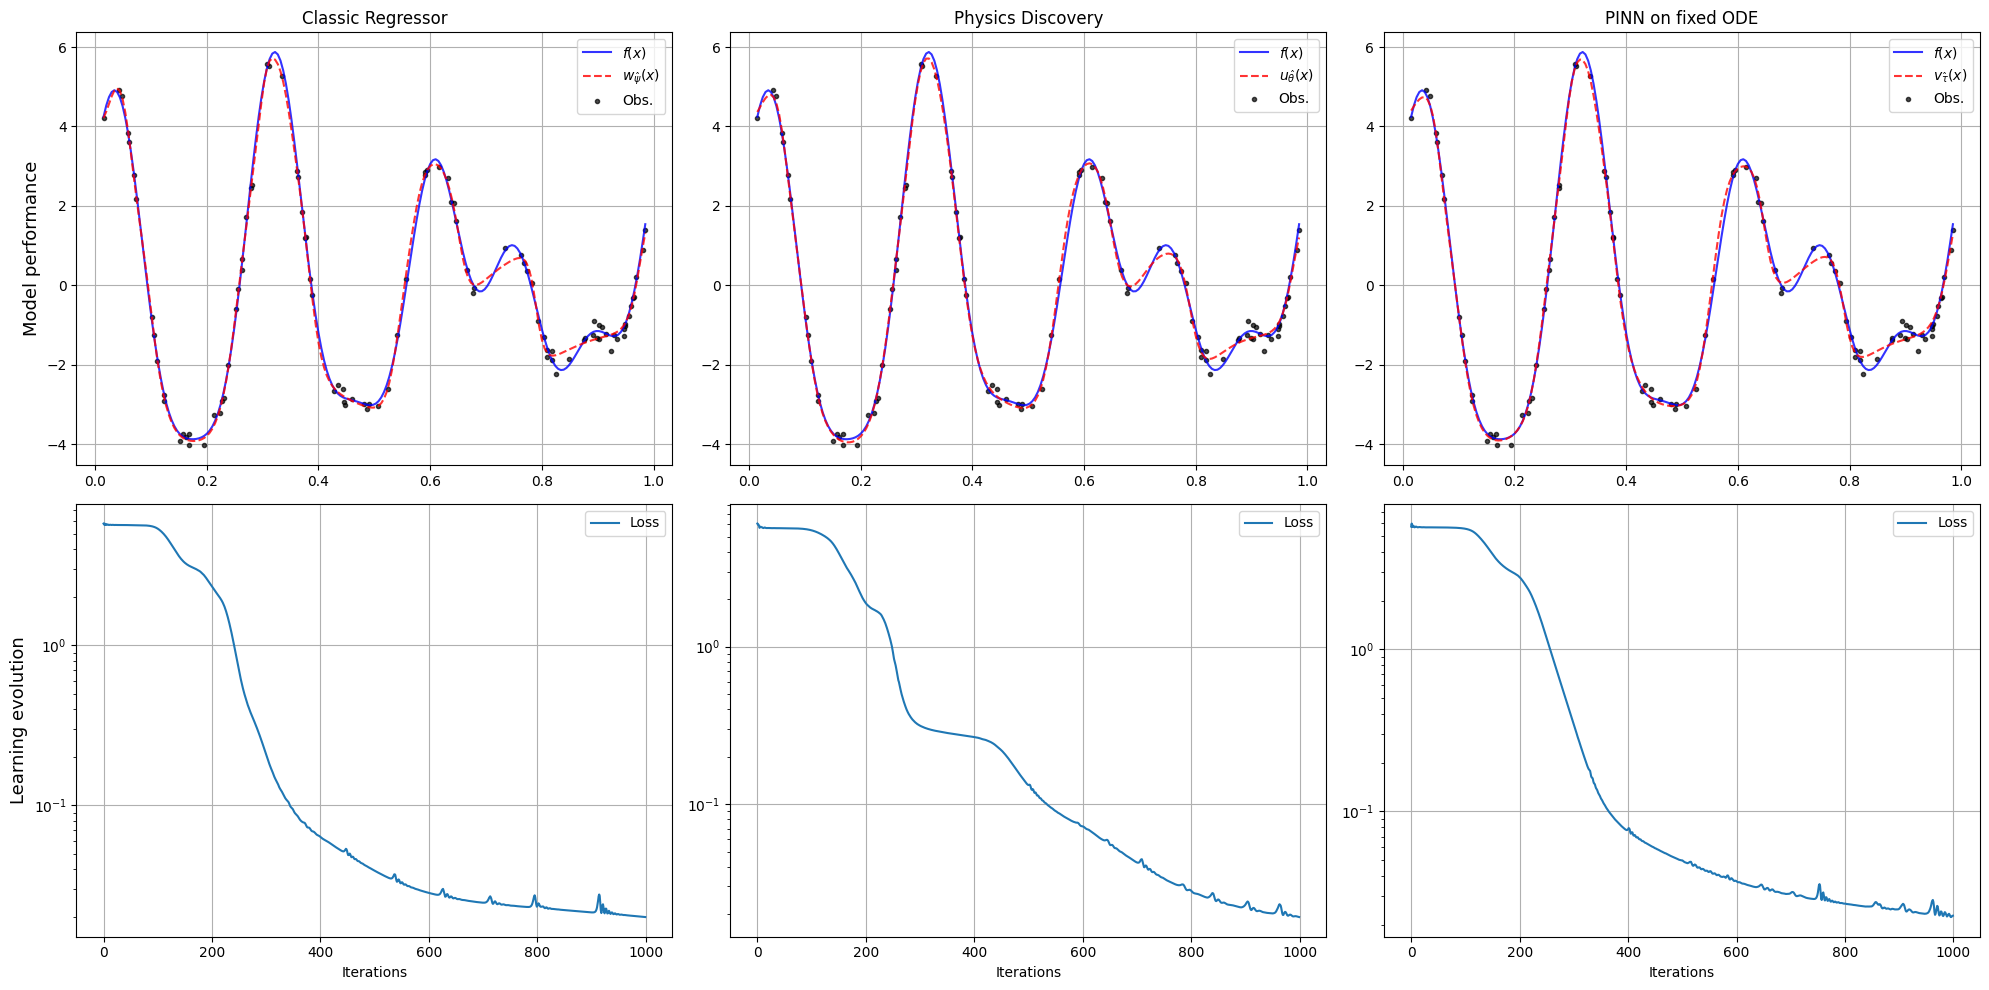

In [69]:
fig,ax = plt.subplots(2,3,figsize=(20,10))
data = zip(
    [w,u,v],
    [r"$w_{\hat\psi}(x)$",r"$u_{\hat\theta}(x)$",r"$v_{\hat\tau}(x)$"],
    ["Classic Regressor", "Physics Discovery", "PINN on fixed ODE"]
)
with torch.no_grad():
    for i,(model, name, problem) in enumerate(data):
        ax[0,i].set_title(problem)
        ax[0,i].plot(
            x_test.cpu().flatten(),
            real_fun(x_test).cpu().flatten(),
            color="blue",
            label=r"$f(x)$",
            alpha=0.8
        )
        ax[0,i].plot(
            x_test.cpu().flatten(),
            model(x_test).cpu().flatten(),
            color="red",
            linestyle="--",
            alpha=0.8,
            label=name
        )
        ax[0,i].scatter(
            x_train.cpu().flatten(),
            y_train.cpu().flatten(),
            color="black",
            alpha=0.7,
            marker=".",
            label="Obs."
        )
        ax[0,i].legend(loc="upper right")
        ax[0,i].set_axisbelow(True)
        ax[0,i].grid()
for i, hist in enumerate([history_w, history_u, history_v]):
    ax[1,i].plot(hist,label="Loss")
    ax[1,i].set_xlabel("Iterations")
    ax[1,i].grid()
    ax[1,i].legend()
    ax[1,i].set_yscale("log")    
    ax[1,i].set_axisbelow(True)
ax[0,0].set_ylabel("Model performance", fontsize=13)
ax[1,0].set_ylabel("Learning evolution", fontsize=13)
plt.tight_layout()
plt.show()